In [59]:
import polyglot
from polyglot.text import Text
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import io
import requests
import itertools
from functions import *
from glob import glob as gb
from tqdm import tqdm
plotting.style_('viridis',12)


In [2]:
base_path = "/home/ruben/Documents/GitHub/ParlaMintCase"

In [109]:
def chen_classifier(text):
    try:
        text = text.split(' ')
        pos_words = set(pd.read_csv(base_path + f'/resources/lexicons/sentiment-lexicons/positive_words_{language}.txt',header=None)[0])
        neg_words = set(pd.read_csv(base_path + f'/resources/lexicons/sentiment-lexicons/negative_words_{language}.txt',header=None)[0])
        s =0
        for w in text:
            if w in pos_words or w in neg_words:
                s += 1
        return s / len(text)
    except Exception:
        print(e)
        return float("nan")

def polyglot_classifier(text):
    try:
        text = Text(text)
        r = sum([w.polarity for w in text.words]) / len(text.words)
        return r
    except Exception:
        print(e)
        return float("nan")

def sentistrength_classifier(text):
    try:
        text = text.split(' ')
        def grouper(n, iterable, fillvalue=None):
            args = [iter(iterable)] * n
            return itertools.zip_longest(*args, fillvalue=fillvalue)

        try:
            with open(base_path + f'/resources/lexicons/sentistrength-lexicons/{language}.txt','r',encoding="utf-8") as f:
                c = [x.replace('\n','').split('\t') for x in f.readlines()]
        except Exception:
            with open(base_path + f'/resources/lexicons/sentistrength-lexicons/{language}.txt','r',encoding='latin-1') as f:
                c = [x.replace('\n','').split('\t') for x in f.readlines()]

        d = [list(grouper(2,x)) for x in c]
        d = [item for sublist in d for item in sublist]
        d = {x[0].replace(u'\xa0', u' ').replace(' ','').lower():int(x[1]) for x in d}
        r = [d[w] if w in d.keys() else 0 for w in text]
        return sum(r) / len(r)
    except Exception:
        print(e)
        return float("nan")

In [114]:
language = 'bg'
data = data_loader.full(language,"lemmatized")
data['date'] = [utils.find_date(x) for x in data['id']]
data = utils.add_metadata(data,language)
data['text'] = utils.preprocess_(data['text'])
#data = data[(data.id.str.contains('sejm'))].reset_index(drop=True)
data = data[(data.id.str.contains('2019|2020'))].reset_index(drop=True)

found 717 files in: /home/ruben/Documents/GitHub/ParlaMintCase/data/original/bg/bg-ana-txt/


In [111]:
data = data[data.text.str.split(' ').str.len() >= 100].reset_index(drop=True)

In [115]:
data = data["id text date speaker_party".split(' ')]
data['c1'] = [chen_classifier(x) for x in data['text']]
data['c2'] = [sentistrength_classifier(x) for x in data['text']]
data['c3'] = [polyglot_classifier(x) for x in data['text']]

NameError: name 'e' is not defined

In [116]:
# fig,ax = plt.subplots(figsize=(20,10))
# colors = {k:sns.color_palette('Paired',12)[c] for c,k in enumerate(list(set(data['speaker_party'])))}
# plt.scatter(data['date'], data['c1'],c=data['speaker_party'].map(colors),alpha=0.3,s=35)
# for label in ax.get_xticklabels():
#     label.set_rotation(90) 
# plt.ylim(0,0.8)
data

id  \
0        ParlaMint-BG_2019-04-17.u1   
1        ParlaMint-BG_2019-04-17.u2   
2        ParlaMint-BG_2019-04-17.u3   
3        ParlaMint-BG_2019-04-17.u4   
4        ParlaMint-BG_2019-04-17.u5   
...                             ...   
31666  ParlaMint-BG_2019-02-15.u191   
31667  ParlaMint-BG_2019-02-15.u192   
31668  ParlaMint-BG_2019-02-15.u193   
31669  ParlaMint-BG_2019-02-15.u194   
31670  ParlaMint-BG_2019-02-15.u195   

                                                    text        date  \
0      има кворум откривамсе заседание уважаем колега...  2019-04-17   
1      гласувам 124 народен представител за 124 проти...  2019-04-17   
2      благодаря уважаем господин председател преди т...  2019-04-17   
3      подлагам на гласуване направясе предложение за...  2019-04-17   
4      благодаря пети доклад за пръв гласуване относн...  2019-04-17   
...                                                  ...         ...   
31666  благодаря аз уважаем господин министър имам ду...  2019-02-15   
31667  господин председател колега господин министър ...  2019-02-15   
31668            благодаря аз уважаем госпожо анастасова  2019-02-15   
31669  един секунда аз знам господин министър че има ...  2019-02-15   
31670  благодаря аз уважаем госпожо анастасова този с...  2019-02-15   

      speaker_party        c1  
0              ГЕРБ  0.079909  
1              ГЕРБ  0.073718  
2              ГЕРБ  0.105263  
3              ГЕРБ  0.066667  
4              ГЕРБ  0.100796  
...             ...       ...  
31666          ГЕРБ  0.083333  
31667           БСП  0.073980  
31668          ГЕРБ  0.200000  
31669           БСП  0.108333  
31670          ГЕРБ  0.100000  

[31671 rows x 5 columns]

In [117]:
data = data.sort_values('date').reset_index(drop=True)

In [118]:
def plot_(cl):
    fig = plt.figure(figsize=(20,5))

    p = sns.stripplot(x="date", y=cl, data=data,jitter=0.2,alpha=.2,color='teal',size=5)
    for label in p.get_xticklabels():
        label.set_rotation(90) 

    avgs = pd.DataFrame([[m,data[data['date'] == m][cl].sum() / len(data[data['date'] == m])] for m in set(data['date'])],columns=['date',cl]).sort_values('date')
    rm = avgs[cl].rolling(window=5).mean()

    plt.plot(avgs['date'],rm)
    plt.show()

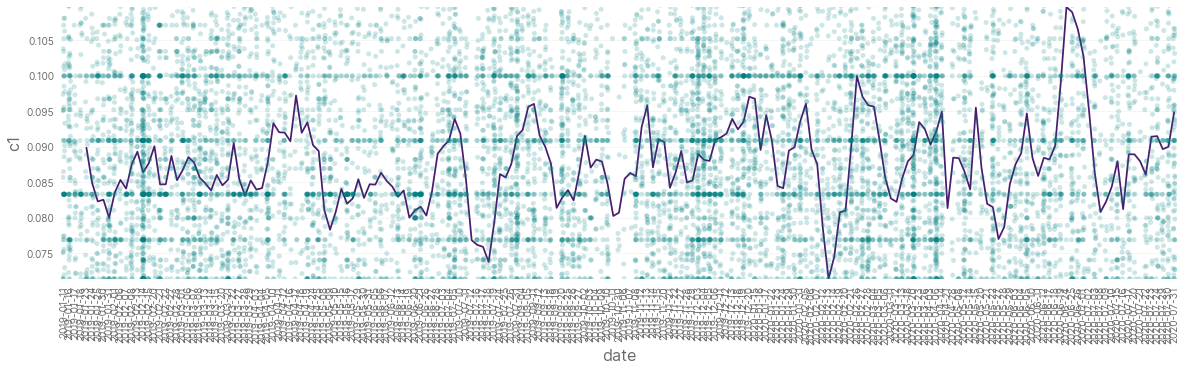

In [119]:
plot_('c1')
# plot_('c2')
# plot_('c3')

In [ ]:
plt.vlines(x=['2020-'])